# LOADING LIBS AND MODULES

In [1]:
# core
import numpy as np
import pandas as pd
import datetime as dt
import os
import yaml
import json
import pickle

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# import shap

# modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import KNNImputer, SimpleImputer

# models
from xgboost import XGBRegressor

# otm
import optuna

# our functions
import utils

c:\Users\yuric\OneDrive\Área de Trabalho\HACKATON\CP007--Hackathon-Forecast-2025--Big-Data\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

# LOADING THE PARAMETER CONFIGURATION FILE

In [3]:
# loading up the YAML dictionary that contains all the parameters for the model
with open("model_params.yml", "r") as f:
    configs = yaml.safe_load(f)

# SETTING UP DEFAULTS AND PARAMETERS

In [ ]:
# showing all columns in a pandas dataframe
pd.options.display.max_columns = None

# extracting the keys associated with the parameters
RANDOM_STATE = configs['RANDOM_STATE']
NUMBER_OF_FOLDS = configs['NUMBER_OF_FOLDS']
STRATIFICATION = configs['STRATIFICATION']
FEATURE_STRATIFICATION = configs['FEATURE_STRATIFICATION']
EVAL_FEATURES = configs['EVAL_FEATURES']

FEATURE_COLUMNS = configs['FEATURES']
LABEL_COLUMNS = configs['TARGET']

PREPROCESSING = configs['PREPROCESSING']

# OPTUNA AND MODEL PARAMS
OPTUNA_PARAMS = configs['OPTUNA_PARAMS']
MODEL_RANGE_PARAMS = OPTUNA_PARAMS['MODEL']

# SHAP PARAMS
SHAP_PARMS = configs['SHAP_PARAMS']
SHAP_SAMPLE = SHAP_PARMS['SHAP_SAMPLE']

# LOADING THE DATA

In [5]:
print("Loading the dataset containing the training data for the demand forecasting model.")
df = pd.read_parquet('../../data/processed/processed_data.parquet')
df = df.sort_values('week_of_year').reset_index(drop=True)
print(f"The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Loading the dataset containing the training data for the demand forecasting model.
The dataset contains 6227874 rows and 25 columns.


In [6]:
# filtering
df = df[~((df.week_of_year == 37) & (df.quantity > df[df.week_of_year == 37].quantity.quantile(0.90)))]

### Fill NaN with -1, indicating a new release in this city

In [7]:
# lista de colunas onde quer aplicar o preenchimento
cols_to_fill_month = ["previous_month_quantity_mean", "previous_month_gross_value_mean", "previous_month_net_value_mean", "previous_month_gross_profit_mean", "previous_month_discount_mean"]

# condição: linhas onde month != 1
mask_month = df["month"] != 1

# aplica apenas nessas linhas
df.loc[mask_month, cols_to_fill_month] = df.loc[mask_month, cols_to_fill_month].fillna(-1)

# lista de colunas onde quer aplicar o preenchimento
cols_to_fill_week = ["previous_week_quantity_mean", "previous_week_gross_value_mean", "previous_week_net_value_mean", "previous_week_gross_profit_mean", "previous_week_discount_mean"]

# condição: linhas onde month != 1
mask_week = df["week_of_year"] != 1

# aplica apenas nessas linhas
df.loc[mask_week, cols_to_fill_week] = df.loc[mask_week, cols_to_fill_week].fillna(-1)

# SEPARATING THE FEATURES BY TYPE

In [8]:
# mapping which columns should be treated as numerical columns - excluding cyclical features
NUMERIC_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes(np.number).columns if column not in PREPROCESSING['CYCLICAL_FEATURES'].keys()]
# mapping which columns should be treated as categorical columns
CATEGORICAL_COLUMNS = [column for column in df[FEATURE_COLUMNS].select_dtypes('object').columns]

# SPLITTING THE DATA

### Mapping which instances should be placed in the train and test splits

In [9]:
# splitting the data into training and testing sets
# training set: all data before December 2022
X_train = df.loc[df.month != 12, FEATURE_COLUMNS]
y_train = df.loc[df.month != 12, [LABEL_COLUMNS]]
# test set: all data from December 2022 onwards
X_test = df.loc[df.month == 12, FEATURE_COLUMNS]
y_test = df.loc[df.month == 12, [LABEL_COLUMNS]]

### Creating the cross validation folds

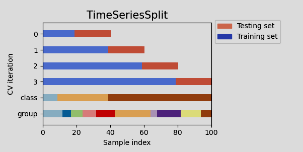

In [10]:
# creating the stratified k fold instance
tscv = TimeSeriesSplit(n_splits=NUMBER_OF_FOLDS)

## TRAINING WITH CROSS VALIDATION

### OTM Hyperparams Optuna

In [11]:
def defining_hyperparams(trial, hyperparam_ranges):
    v1 = trial.suggest_int('max_depth', hyperparam_ranges['max_depth'][0], hyperparam_ranges['max_depth'][1], log=hyperparam_ranges['max_depth'][2])
    v2 = trial.suggest_int('n_estimators', hyperparam_ranges['n_estimators'][0], hyperparam_ranges['n_estimators'][1], log=hyperparam_ranges['n_estimators'][2])
    v3 = trial.suggest_float('learning_rate', hyperparam_ranges['learning_rate'][0], hyperparam_ranges['learning_rate'][1], log=hyperparam_ranges['learning_rate'][2])
    v4 = trial.suggest_float('reg_alpha', hyperparam_ranges['reg_alpha'][0], hyperparam_ranges['reg_alpha'][1], log=hyperparam_ranges['reg_alpha'][2])
    v5 = trial.suggest_float('reg_lambda', hyperparam_ranges['reg_lambda'][0], hyperparam_ranges['reg_lambda'][1], log=hyperparam_ranges['reg_lambda'][2])
    v6 = trial.suggest_float('min_child_weight', hyperparam_ranges['min_child_weight'][0], hyperparam_ranges['min_child_weight'][1], log=hyperparam_ranges['min_child_weight'][2])
    v7 = trial.suggest_float('subsample', hyperparam_ranges['subsample'][0], hyperparam_ranges['subsample'][1], log=hyperparam_ranges['subsample'][2])
    v8 = trial.suggest_float('colsample_bytree', hyperparam_ranges['colsample_bytree'][0], hyperparam_ranges['colsample_bytree'][1], log=hyperparam_ranges['colsample_bytree'][2])
    return {'max_depth':v1, 'n_estimators':v2, 'learning_rate':v3, 'reg_alpha':v4,
            'reg_lambda':v5, 'min_child_weight':v6, 'subsample':v7, 'colsample_bytree':v8}

In [12]:
# Configuring and execute the study
study = optuna.create_study(study_name='best_model', directions=[OPTUNA_PARAMS['DIRECTION'], OPTUNA_PARAMS['DIRECTION']])
study.set_metric_names(["score_validation", "score_overfitting"])

study.optimize(utils.create_objective_function(hyperparam_ranges            = MODEL_RANGE_PARAMS,
                                            tscv                            = tscv,
                                            x_data                          = [X_train,y_train],
                                            regressor_model                 = XGBRegressor,
                                            columns_to_use                  = [FEATURE_COLUMNS, LABEL_COLUMNS, NUMERIC_COLUMNS, CATEGORICAL_COLUMNS],
                                            eval_features                   = EVAL_FEATURES,
                                            preprocessing                   = PREPROCESSING,
                                            random_state                    = RANDOM_STATE,
                                            defining_hyperparams_function   = defining_hyperparams,
                                            multi_scores                    = True),
                                            n_trials                        = OPTUNA_PARAMS['TRIALS']
)

[I 2025-09-17 22:27:46,269] A new study created in memory with name: best_model


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   57.84899365922701.
[Fold 1] WMAPE Validation: 55.3199765377801.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   55.84037485299793.
[Fold 2] WMAPE Validation: 54.39658841180768.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   55.22954897634181.
[Fold 3] WMAPE Validation: 83.68459679436798.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   63.12182870357469.
[Fold 4] WMAPE Validation: 112.74673179495296.


[I 2025-09-17 22:41:31,971] Trial 0 finished with values: {'score_validation': 76.53697338472718, 'score_overfitting': 18.52678683669182} and parameters: {'max_depth': 4, 'n_estimators': 1874, 'learning_rate': 0.07408442859463599, 'reg_alpha': 3.246628584413869, 'reg_lambda': 1.3853417157368884, 'min_child_weight': 55.91921999058458, 'subsample': 0.5183597010633609, 'colsample_bytree': 0.3759645367517631}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   56.688612015051945.
[Fold 1] WMAPE Validation: 54.09014292715012.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   54.76536783665471.
[Fold 2] WMAPE Validation: 53.22509361676967.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   54.17248890363147.
[Fold 3] WMAPE Validation: 80.83611471511854.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   62.39974122447958.
[Fold 4] WMAPE Validation: 101.26715006658213.


[I 2025-09-17 22:58:26,126] Trial 1 finished with values: {'score_validation': 72.35462533140512, 'score_overfitting': 15.34807283645069} and parameters: {'max_depth': 6, 'n_estimators': 1910, 'learning_rate': 0.020495557154895296, 'reg_alpha': 0.015835940636424795, 'reg_lambda': 4.000273119026652, 'min_child_weight': 175.07932230800267, 'subsample': 0.9208061080469275, 'colsample_bytree': 0.3528881980258338}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   59.42219105941541.
[Fold 1] WMAPE Validation: 56.411870205689375.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   57.34924765330969.
[Fold 2] WMAPE Validation: 55.559297078607685.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   56.53993983093106.
[Fold 3] WMAPE Validation: 80.8725754308733.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   64.33034808369621.
[Fold 4] WMAPE Validation: 116.29795673314966.


[I 2025-09-17 23:09:31,170] Trial 2 finished with values: {'score_validation': 77.28542486208, 'score_overfitting': 17.874993205241914} and parameters: {'max_depth': 3, 'n_estimators': 1328, 'learning_rate': 0.05473509793044019, 'reg_alpha': 0.31788497628306767, 'reg_lambda': 0.034620487603676864, 'min_child_weight': 78.33323374532861, 'subsample': 0.4765260187225597, 'colsample_bytree': 0.5475767188391575}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   61.96410613760746.
[Fold 1] WMAPE Validation: 58.62833949213536.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   59.8164176498575.
[Fold 2] WMAPE Validation: 58.317009126524134.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   59.044910257114466.
[Fold 3] WMAPE Validation: 81.81179468192707.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   66.72899225146426.
[Fold 4] WMAPE Validation: 108.37378417336818.


[I 2025-09-17 23:19:58,455] Trial 3 finished with values: {'score_validation': 76.78273186848868, 'score_overfitting': 14.894125294477764} and parameters: {'max_depth': 2, 'n_estimators': 1273, 'learning_rate': 0.028348180656800073, 'reg_alpha': 1.4411295087471752, 'reg_lambda': 6.674320954978955, 'min_child_weight': 29.57567448842118, 'subsample': 0.33707072794950493, 'colsample_bytree': 0.6585431453167844}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   61.03703692642418.
[Fold 1] WMAPE Validation: 57.6365979807949.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   59.0425265149103.
[Fold 2] WMAPE Validation: 57.94464892834294.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   58.41987483813115.
[Fold 3] WMAPE Validation: 81.73538418877759.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   66.0656812798044.
[Fold 4] WMAPE Validation: 116.66064329855246.


[I 2025-09-17 23:29:55,028] Trial 4 finished with values: {'score_validation': 78.49431859911698, 'score_overfitting': 17.35303870929947} and parameters: {'max_depth': 3, 'n_estimators': 914, 'learning_rate': 0.010076401890175394, 'reg_alpha': 13.61049994431397, 'reg_lambda': 1.5023611784917092, 'min_child_weight': 18.903028493904113, 'subsample': 0.3471306223600118, 'colsample_bytree': 0.8530695236672383}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   62.31261336033735.
[Fold 1] WMAPE Validation: 59.11577759060403.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   59.720716082306154.
[Fold 2] WMAPE Validation: 57.83981755291375.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   58.905244204937155.
[Fold 3] WMAPE Validation: 81.01619053179854.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   66.67697114092702.
[Fold 4] WMAPE Validation: 105.32806646271875.


[I 2025-09-17 23:38:32,334] Trial 5 finished with values: {'score_validation': 75.82496303450877, 'score_overfitting': 13.921076837381849} and parameters: {'max_depth': 2, 'n_estimators': 645, 'learning_rate': 0.09608212941424187, 'reg_alpha': 0.2121221686964179, 'reg_lambda': 13.626026016767106, 'min_child_weight': 25.01543104990202, 'subsample': 0.4631480787904752, 'colsample_bytree': 0.31381477733617474}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   57.663981962366776.
[Fold 1] WMAPE Validation: 54.941776448865056.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   55.78921742490298.
[Fold 2] WMAPE Validation: 54.24919158509599.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   55.176534143779776.
[Fold 3] WMAPE Validation: 81.72987493114586.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   63.12350828252797.
[Fold 4] WMAPE Validation: 127.21735183645346.


[I 2025-09-17 23:48:41,934] Trial 6 finished with values: {'score_validation': 79.53454870039009, 'score_overfitting': 21.596238246995718} and parameters: {'max_depth': 5, 'n_estimators': 718, 'learning_rate': 0.038171411674510505, 'reg_alpha': 1.0293671883307607, 'reg_lambda': 8.336070416490989, 'min_child_weight': 32.196587720642704, 'subsample': 0.435884974380148, 'colsample_bytree': 0.8891894114968563}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   61.92422789733678.
[Fold 1] WMAPE Validation: 58.62971408968004.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   59.83646644146396.
[Fold 2] WMAPE Validation: 58.61181250669648.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   59.13229003498913.
[Fold 3] WMAPE Validation: 82.68931651016543.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   66.73138266568738.
[Fold 4] WMAPE Validation: 105.92002887605287.


[I 2025-09-17 23:56:50,661] Trial 7 finished with values: {'score_validation': 76.4627179956487, 'score_overfitting': 14.556626235779392} and parameters: {'max_depth': 3, 'n_estimators': 373, 'learning_rate': 0.015215522233919835, 'reg_alpha': 4.790042536778081, 'reg_lambda': 0.3125602017756653, 'min_child_weight': 267.83125613462795, 'subsample': 0.5721331531572124, 'colsample_bytree': 0.9000890310480502}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   62.89888873384829.
[Fold 1] WMAPE Validation: 59.64089468971265.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   60.76829907638882.
[Fold 2] WMAPE Validation: 59.109812148887244.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   59.82530368920007.
[Fold 3] WMAPE Validation: 81.1865638349941.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   67.3340808472215.
[Fold 4] WMAPE Validation: 107.27829953131331.


[I 2025-09-18 00:07:02,766] Trial 8 finished with values: {'score_validation': 76.80389255122682, 'score_overfitting': 14.097249464562157} and parameters: {'max_depth': 2, 'n_estimators': 1094, 'learning_rate': 0.02466295963779933, 'reg_alpha': 0.3150036162502211, 'reg_lambda': 11.012646960637968, 'min_child_weight': 52.20445490881524, 'subsample': 0.6461287364778524, 'colsample_bytree': 0.312352825682646}. 


[Fold 1] Training fold: 1132614 samples
[Fold 1] Creating the preprocessing and modeling pipeline.
[Fold 1] Fitting the model to the data.
[Fold 1] WMAPE Training:   58.926660189915104.
[Fold 1] WMAPE Validation: 55.73331248143224.
[Fold 2] Training fold: 2265226 samples
[Fold 2] Creating the preprocessing and modeling pipeline.
[Fold 2] Fitting the model to the data.
[Fold 2] WMAPE Training:   56.987568212513665.
[Fold 2] WMAPE Validation: 55.08021829145595.
[Fold 3] Training fold: 3397838 samples
[Fold 3] Creating the preprocessing and modeling pipeline.
[Fold 3] Fitting the model to the data.
[Fold 3] WMAPE Training:   56.48762153838687.
[Fold 3] WMAPE Validation: 80.43343725236954.
[Fold 4] Training fold: 4530450 samples
[Fold 4] Creating the preprocessing and modeling pipeline.
[Fold 4] Fitting the model to the data.
[Fold 4] WMAPE Training:   64.27590316772189.
[Fold 4] WMAPE Validation: 124.00488496223532.


[I 2025-09-18 00:17:08,025] Trial 9 finished with values: {'score_validation': 78.81296324687327, 'score_overfitting': 19.643524969738884} and parameters: {'max_depth': 4, 'n_estimators': 747, 'learning_rate': 0.021169926977976938, 'reg_alpha': 0.1293796032285937, 'reg_lambda': 0.7602866212439027, 'min_child_weight': 16.218681371750826, 'subsample': 0.9271468821147466, 'colsample_bytree': 0.7344368193922536}. 


In [13]:
# saving best params of otm optuna into variable
_, best_params = utils.get_best_params(study)
print(best_params)

{'max_depth': 6, 'n_estimators': 1910, 'learning_rate': 0.020495557154895296, 'reg_alpha': 0.015835940636424795, 'reg_lambda': 4.000273119026652, 'min_child_weight': 175.07932230800267, 'subsample': 0.9208061080469275, 'colsample_bytree': 0.3528881980258338}


## TRAINING WITH BEST PARAMS

In [14]:
# dataframe with the predictions and expected values
df_results = pd.DataFrame()

# dataframe to hold important features of models
df_feature_importances = pd.DataFrame()

# dictionary to hold the cross validation results from each fold

## FITTING THE MODEL THE LAST TIME

### Re-creating the pre-processing pipeline

In [15]:
pipe_preproc = utils.create_preprocessing_pipeline(preprocessing_configs=PREPROCESSING, numeric_columns=NUMERIC_COLUMNS, categorical_columns=CATEGORICAL_COLUMNS)

### Fitting the model  to the training data

In [16]:
pipeline = Pipeline(steps=[
    ('preprocessor', pipe_preproc), ('model', XGBRegressor(**best_params, random_state=RANDOM_STATE))
])

# training the model
pipeline.fit(X_train.loc[:, FEATURE_COLUMNS], y_train.loc[:, LABEL_COLUMNS].values.ravel())

KeyboardInterrupt: 

### Evaluating model performance

In [ ]:
# creating a reference copy of the training and test data
X_train = df.loc[X_train.index].copy()
X_test = df.loc[X_test.index].copy()
train, test = X_train.loc[:, EVAL_FEATURES + [LABEL_COLUMNS]], X_test.loc[:, EVAL_FEATURES + [LABEL_COLUMNS]]

# getting the predictions for the training and test sets
train['predicted'] = pipeline.predict(X_train.loc[:, FEATURE_COLUMNS])
test['predicted'] = pipeline.predict(X_test.loc[:, FEATURE_COLUMNS])

# rounding train and test predictions
train['predicted_rounded'] = np.round(train['predicted'].values).astype(np.int32)
test['predicted_rounded'] = np.round(test['predicted'].values).astype(np.int32)

In [ ]:
# calculating the error for the training and test sets
error_train = utils.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted'].values)
error_test = utils.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted'].values)

error_train_rounded = utils.wmape_score(y_true = train[LABEL_COLUMNS].values, y_pred = train['predicted_rounded'].values)
error_test_rounded = utils.wmape_score(y_true = test[LABEL_COLUMNS].values, y_pred = test['predicted_rounded'].values)

print(f"WMAPE Train: {error_train:.3f}%")
print(f"WMAPE Test: {error_test:.3f}%")

print(f"WMAPE Train Rounded: {error_train_rounded:.3f}%")
print(f"WMAPE Test Rounded: {error_test_rounded:.3f}%")

## SAVING RESULTS

In [ ]:
output_directory = f"outputs/{dt.datetime.now().strftime(format= '%Y%m%d%H%M')}_XGBOOST/"
output_model_directory = output_directory + 'model'
output_data_directory = output_directory + 'data'
output_params_directory = output_directory + 'params'
output_optuna_directory = output_directory + 'study'

for directory in [output_model_directory, output_data_directory, output_params_directory, output_params_directory, output_optuna_directory]:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
# saving the json dictionary with the parameters
with open(f'{output_params_directory}/exepriment_params.json', 'w') as f:
    configs_all = {**configs, **best_params}
    json.dump(configs_all, f, indent=4)

# datasets
X_train.to_parquet(f'{output_data_directory}/training_set.parquet', index=False)
X_test.to_parquet(f'{output_data_directory}/test_set.parquet', index=False)

# pipeline
with open(f'{output_model_directory}/pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

# saving study
with open(f'{output_optuna_directory}/best_metric_study.pkl', 'wb') as f:
    pickle.dump(study, f)